In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import torch

In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download dogs-vs-cats --force

 98% 796M/812M [00:03<00:00, 254MB/s]
100% 812M/812M [00:03<00:00, 247MB/s]


In [ ]:
# import opendatasets as od
# od.download('https://www.kaggle.com/competitions/dogs-vs-cats/data')

In [ ]:
# ! unzip  ../content/dogs-vs-cats/train.zip
# ! unzip  ../content/dogs-vs-cats/test1.zip

In [ ]:
! unzip  ../content/dogs-vs-cats.zip

Archive:  ../content/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
! unzip  ../content/train.zip
! unzip  ../content/test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [ ]:
train_files = os.listdir("../content/train")

In [ ]:
train_files[:10]

['cat.11683.jpg',
 'cat.8693.jpg',
 'cat.8387.jpg',
 'dog.4639.jpg',
 'cat.5262.jpg',
 'dog.11115.jpg',
 'dog.4369.jpg',
 'cat.8639.jpg',
 'cat.858.jpg',
 'cat.3862.jpg']

In [ ]:
train_files[0].split(".")[0]

'cat'

In [ ]:
labels = []
labels.append(['cat' if train_files[i].split(".")[0] == 'cat' else 'dog' for i in range(len(train_files))])

In [ ]:
labels = labels[0]
labels[:10]

['cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat']

In [ ]:
df = pd.DataFrame([train_files, labels], index = ['file', 'label']).T
df.head()

,file,label
0,cat.11683.jpg,cat
1,cat.8693.jpg,cat
2,cat.8387.jpg,cat
3,dog.4639.jpg,dog
4,cat.5262.jpg,cat


In [ ]:
len(df)

25000

#### Test

In [ ]:
test_files = os.listdir("../content/test1")

In [ ]:
test_labels = []
test_labels.append(['cat' if test_files[j].split(".")[0] == 'cat' else 'dog' for j in range(len(test_files))])

In [ ]:
test_labels = test_labels[0]

In [ ]:
test_df = pd.DataFrame([test_files, test_labels], index = ['file', 'label']).T
test_df.head()

,file,label
0,7075.jpg,dog
1,10817.jpg,dog
2,2439.jpg,dog
3,6726.jpg,dog
4,9616.jpg,dog


#### Split into train and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.1, random_state = 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# train_datagen = ImageDataGenerator(rescale = 1/255)
# valid_datagen = ImageDataGenerator(rescale = 1/255)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 40,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale = 1/255)

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1/255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                    directory = '../content/train/',
                                                    x_col = "file",
                                                    y_col = "label")

valid_generator = valid_datagen.flow_from_dataframe(dataframe = valid_df,
                                                    directory = '../content/train/',
                                                    x_col = "file",
                                                    y_col = "label")

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(dataframe = test_df,
                                                    directory = '../content/test1/',
                                                    x_col = "file",
                                                    y_col = "label")

Found 12500 validated image filenames belonging to 1 classes.


In [ ]:
# Build model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 256x256 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron.
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

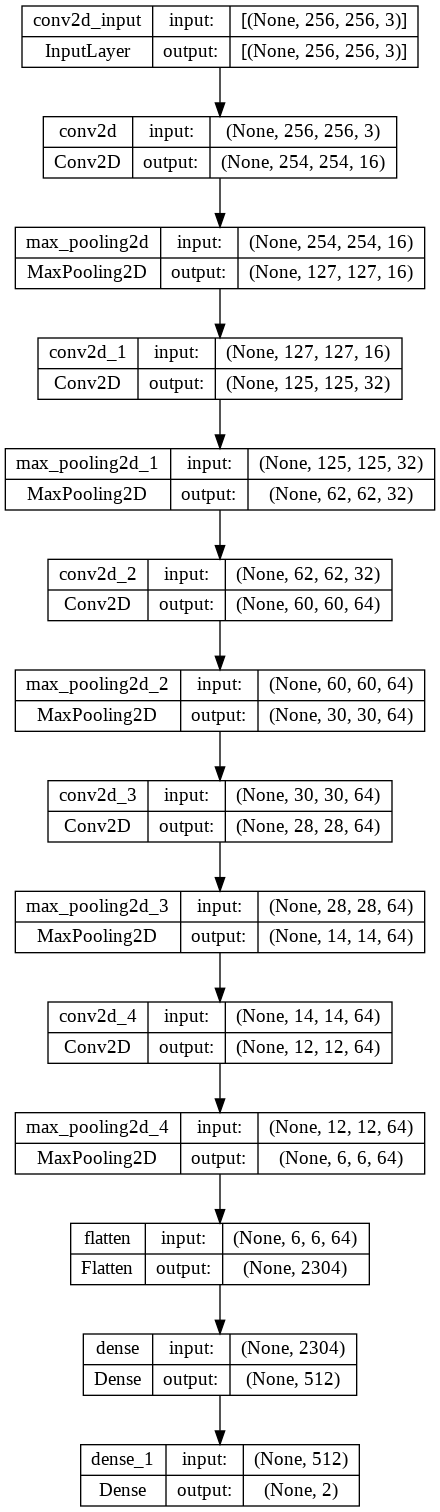

In [ ]:
keras.utils.plot_model(model, "model1.png", show_shapes = True)

[How to save Model history using csvlogger](https://stackoverflow.com/questions/47843265/how-can-i-get-a-keras-models-history-after-loading-it-from-a-file-in-python)

In [ ]:
from keras.callbacks import CSVLogger

In [ ]:
csv_logger = CSVLogger('training.log', separator=',', append=False)

In [ ]:
"""model.fit(train_generator,
              epochs = 7,
              validation_data = valid_generator, callbacks = [csv_logger])"""

Epoch 1/7
704/704 [==============================] - 354s 500ms/step - loss: 0.6251 - accuracy: 0.6417 - val_loss: 0.5616 - val_accuracy: 0.7216
Epoch 2/7
704/704 [==============================] - 350s 497ms/step - loss: 0.5344 - accuracy: 0.7314 - val_loss: 0.4625 - val_accuracy: 0.7756
Epoch 3/7
704/704 [==============================] - 354s 502ms/step - loss: 0.4636 - accuracy: 0.7812 - val_loss: 0.4103 - val_accuracy: 0.8104
Epoch 4/7
704/704 [==============================] - 355s 504ms/step - loss: 0.4017 - accuracy: 0.8176 - val_loss: 0.3708 - val_accuracy: 0.8396
Epoch 5/7
704/704 [==============================] - 356s 505ms/step - loss: 0.3603 - accuracy: 0.8401 - val_loss: 0.3240 - val_accuracy: 0.8616
Epoch 6/7
704/704 [==============================] - 360s 512ms/step - loss: 0.3307 - accuracy: 0.8561 - val_loss: 0.3069 - val_accuracy: 0.8724
Epoch 7/7
704/704 [==============================] - 355s 504ms/step - loss: 0.3027 - accuracy: 0.8682 - val_loss: 0.3109 - val_ac

In [ ]:
log_data = pd.read_csv('training.log', sep=',', engine='python')

In [ ]:
log_data

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.641689,0.625129,0.7216,0.561571
1,1,0.731422,0.534428,0.7756,0.462482
2,2,0.781156,0.463586,0.8104,0.410325
3,3,0.817600,0.401679,0.8396,0.370793
4,4,0.840133,0.360259,0.8616,0.324044
5,5,0.856089,0.330697,0.8724,0.306881
6,6,0.868178,0.302676,0.8668,0.310932


In [ ]:
# tf.keras.models.save_model(model, '../content/catvdogmodel1.h5')

In [ ]:
#loaded_model = tf.keras.models.load_model('../content/catvdogmodel1.h5')

In [ ]:
model.evaluate(test_generator)

391/391 [==============================] - 43s 111ms/step - loss: 4.8463 - accuracy: 0.5652


[4.846292018890381, 0.5651999711990356]

### Transfer Learning

#### VGG16

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
input = keras.Input(shape = (256, 256, 3))
vgg_model_orig = VGG16(include_top = False, input_tensor = input, pooling = 'avg', weights = 'imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_model_orig.trainable = False

In [ ]:
vgg_model_orig.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

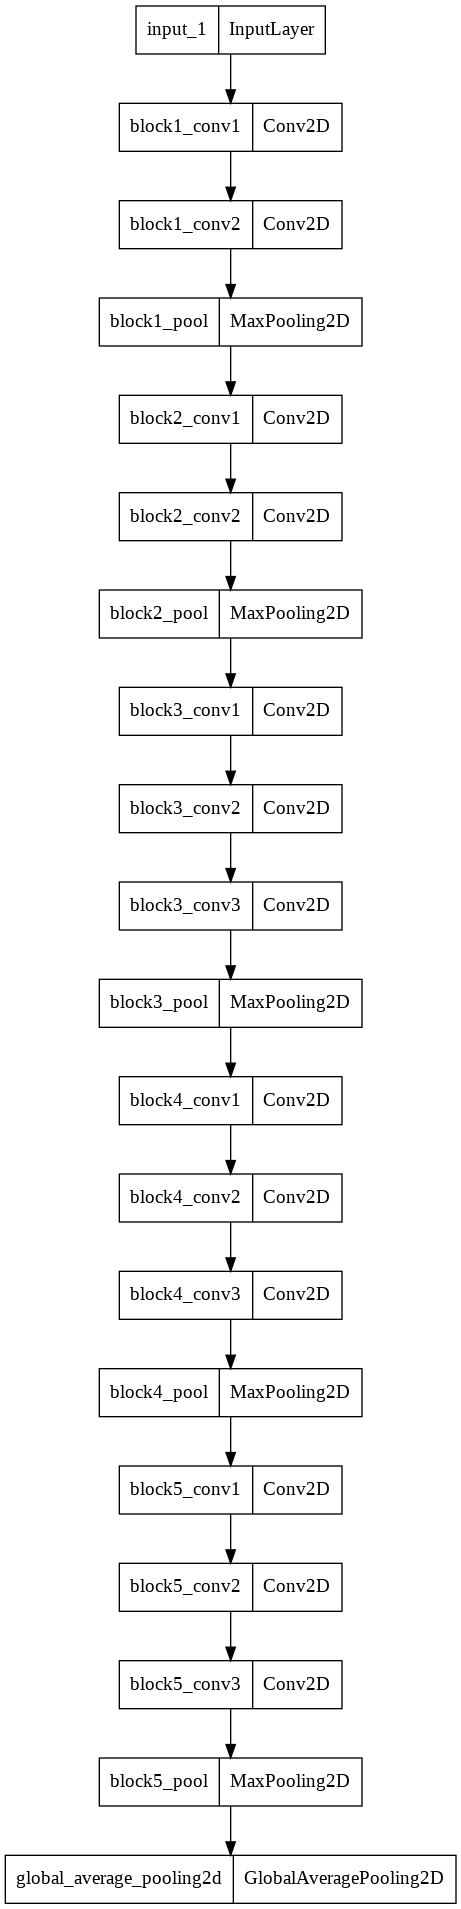

In [ ]:
keras.utils.plot_model(vgg_model_orig, 'vgg_model.png')

In [ ]:
vgg_model = keras.Sequential(vgg_model_orig)
# vgg_model.add(keras.layers.Dense(512, activation = 'relu'))
# vgg_model.add(keras.layers.Dense(128, activation = 'relu'))
# vgg_model.add(keras.layers.Dense(32, activation = 'relu'))
vgg_model.add(keras.layers.Dense(2, activation = 'softmax'))

In [ ]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
vgg_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
vgg_logger = CSVLogger('vgg_training.log', separator=',', append=False)

In [ ]:
vgg_model.fit(train_generator,
              epochs = 7,
              validation_data = valid_generator, callbacks = [vgg_logger])

Epoch 1/7
704/704 [==============================] - 400s 554ms/step - loss: 0.5413 - accuracy: 0.7858 - val_loss: 0.4121 - val_accuracy: 0.8508
Epoch 2/7
704/704 [==============================] - 389s 552ms/step - loss: 0.4156 - accuracy: 0.8479 - val_loss: 0.3339 - val_accuracy: 0.8804
Epoch 3/7
704/704 [==============================] - 387s 550ms/step - loss: 0.3632 - accuracy: 0.8644 - val_loss: 0.2930 - val_accuracy: 0.8924
Epoch 4/7
704/704 [==============================] - 388s 551ms/step - loss: 0.3338 - accuracy: 0.8733 - val_loss: 0.2642 - val_accuracy: 0.9020
Epoch 5/7
704/704 [==============================] - 384s 545ms/step - loss: 0.3127 - accuracy: 0.8784 - val_loss: 0.2448 - val_accuracy: 0.9076
Epoch 6/7
704/704 [==============================] - 383s 544ms/step - loss: 0.2997 - accuracy: 0.8824 - val_loss: 0.2417 - val_accuracy: 0.9028
Epoch 7/7
704/704 [==============================] - 384s 546ms/step - loss: 0.2888 - accuracy: 0.8868 - val_loss: 0.2231 - val_ac